# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm3'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m3



## Measuring Gradient Variance Decay

In [7]:
num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
def sampleM3Var():
# Generate the pre-trained circuits
    pre_trained_block = [preTrainedBlockGenerator(n, int(np.floor(n/2))) for n in num_qubits]

    ansatzes_m3 = []
    for i in range(len(pre_trained_block)):
        ansatzes_m3.append(pre_trained_block[i]['circuit'])

    parameters_m3 = []
    for i in range(len(pre_trained_block)):
        parameters_m3.append(list(pre_trained_block[i]['params_values'].values()))

    gradients_m0 = sampleAnsatz(estimator, ansatzes_m3, G_O, parameters_m3)

    variance = getVariance(gradients_m0, num_qubits)
    
    return variance

## Cost Function Surface

In [9]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)


id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

In [10]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [11]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [12]:
res = pd.DataFrame()
epochs = 200

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,3.466419,-3.573368,-2.234140,-5.600534,-5.554752,-3.854246,-0.592875,-0.190995,-4.596475,-3.325842,...,4.122407,5.397820,3.419044,-3.316519,-5.258496,-4.083393,-4.874221,-2.616016,0.732943,1.015896
1,3.400382,-3.507750,-2.237365,-5.681838,-5.658321,-3.847968,-0.420956,-0.293296,-4.412069,-3.416350,...,4.139292,5.349032,3.372474,-3.367395,-5.299582,-4.032370,-4.724698,-2.678668,0.710470,1.018467
2,3.308447,-3.500763,-2.151347,-5.643537,-5.660493,-3.847117,-0.447357,-0.343274,-4.511205,-3.333735,...,4.149702,5.302575,3.226440,-3.260263,-5.355902,-4.113405,-4.828763,-2.622774,0.706844,0.994279
3,3.303433,-3.576733,-2.163894,-5.543845,-5.723444,-3.890591,-0.520040,-0.331149,-4.482219,-3.343283,...,4.098460,5.383428,3.238599,-3.356138,-5.240042,-4.056350,-4.782546,-2.654865,0.625295,1.019917
4,3.363991,-3.673039,-2.179873,-5.561057,-5.721873,-3.781777,-0.459381,-0.317202,-4.410614,-3.365927,...,4.155047,5.339097,3.280316,-3.402536,-5.369211,-4.093185,-4.737090,-2.746431,0.633289,0.998198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,3.381846,-3.482800,-2.163951,-5.654016,-5.697933,-3.931783,-0.545624,-0.293115,-4.562297,-3.331671,...,4.097504,5.280023,3.306278,-3.399949,-5.230119,-4.123150,-4.840419,-2.575000,0.754571,0.991676
195,3.383318,-3.625991,-2.093664,-5.570920,-5.546563,-3.938413,-0.539297,-0.240562,-4.525362,-3.305309,...,4.049983,5.343097,3.387182,-3.383926,-5.270020,-4.203645,-4.749943,-2.611737,0.676857,1.038599
196,3.457148,-3.503856,-2.234195,-5.556863,-5.630499,-3.861238,-0.566614,-0.267280,-4.441175,-3.263827,...,4.195837,5.257987,3.238691,-3.243394,-5.334287,-4.131017,-4.862296,-2.711725,0.777485,0.988034
197,3.359403,-3.530744,-2.160233,-5.683352,-5.575144,-3.908711,-0.604692,-0.286065,-4.529887,-3.458968,...,4.205316,5.249913,3.250013,-3.301184,-5.283637,-4.071749,-4.864629,-2.761330,0.673760,1.010759


In [13]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{len(ansatz.qubits)}\n'+
      f'\tId Blocks:\t\t{MAX_IDENTITIES_BLOCKS}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		8
	Id Blocks:		3
	Weights:	114
	Epochs:		200)
	Time:		521.27 sec


## Measure Training Performance

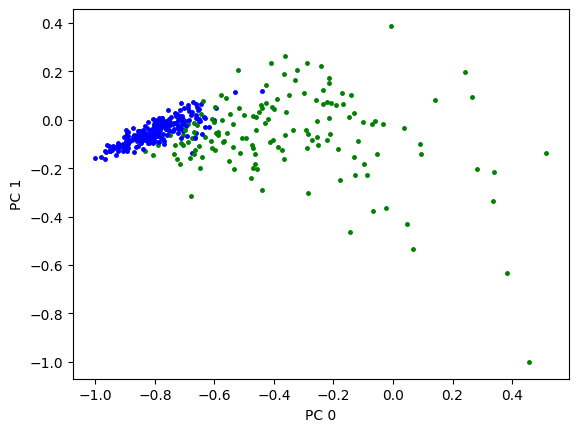

Blue: torch.Size([250])
Green: torch.Size([148])


In [14]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

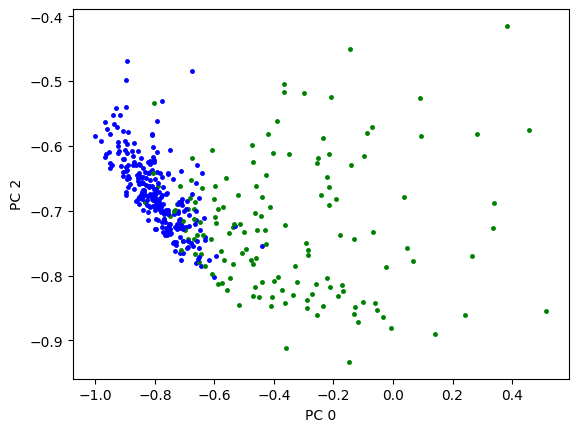

Blue: torch.Size([250])
Green: torch.Size([148])


In [15]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [16]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)

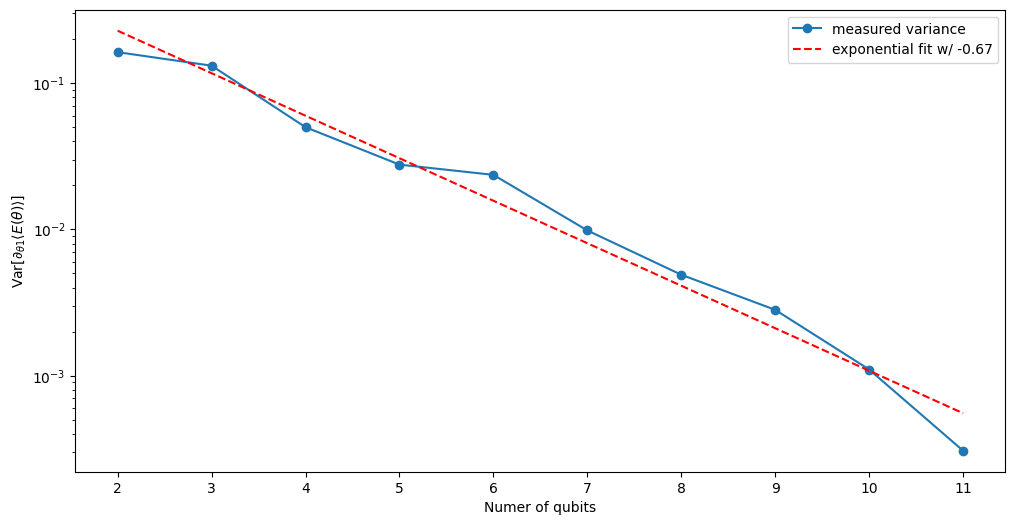

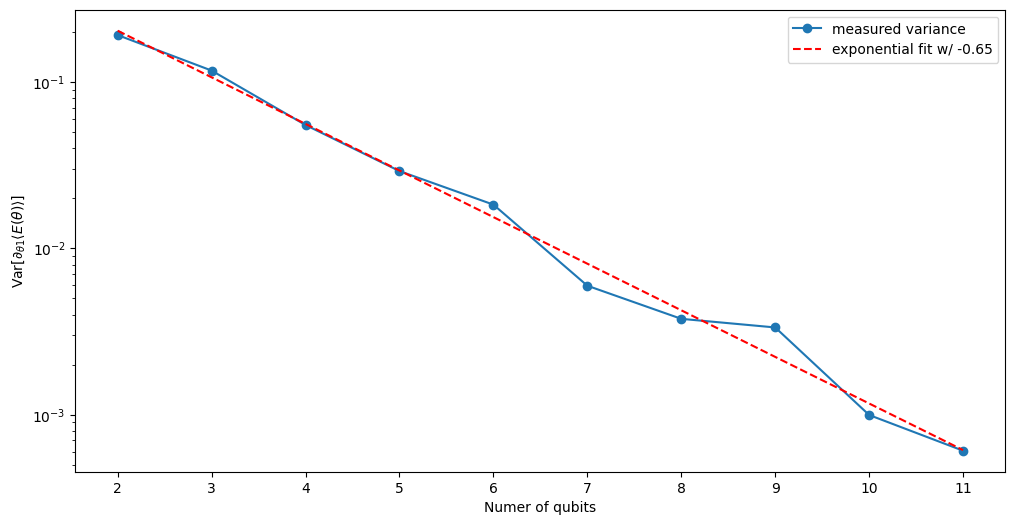

In [17]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [6, 7]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m3_variances = sampleM3Var()
        
    # The identity block returns parameters in order different to that in the ansatz
    identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
    id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
    initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() # MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m3_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

In [18]:
print(f'\nAverage time / instance: {np.average(times)}')


Average time / instance: 41886.0952681303


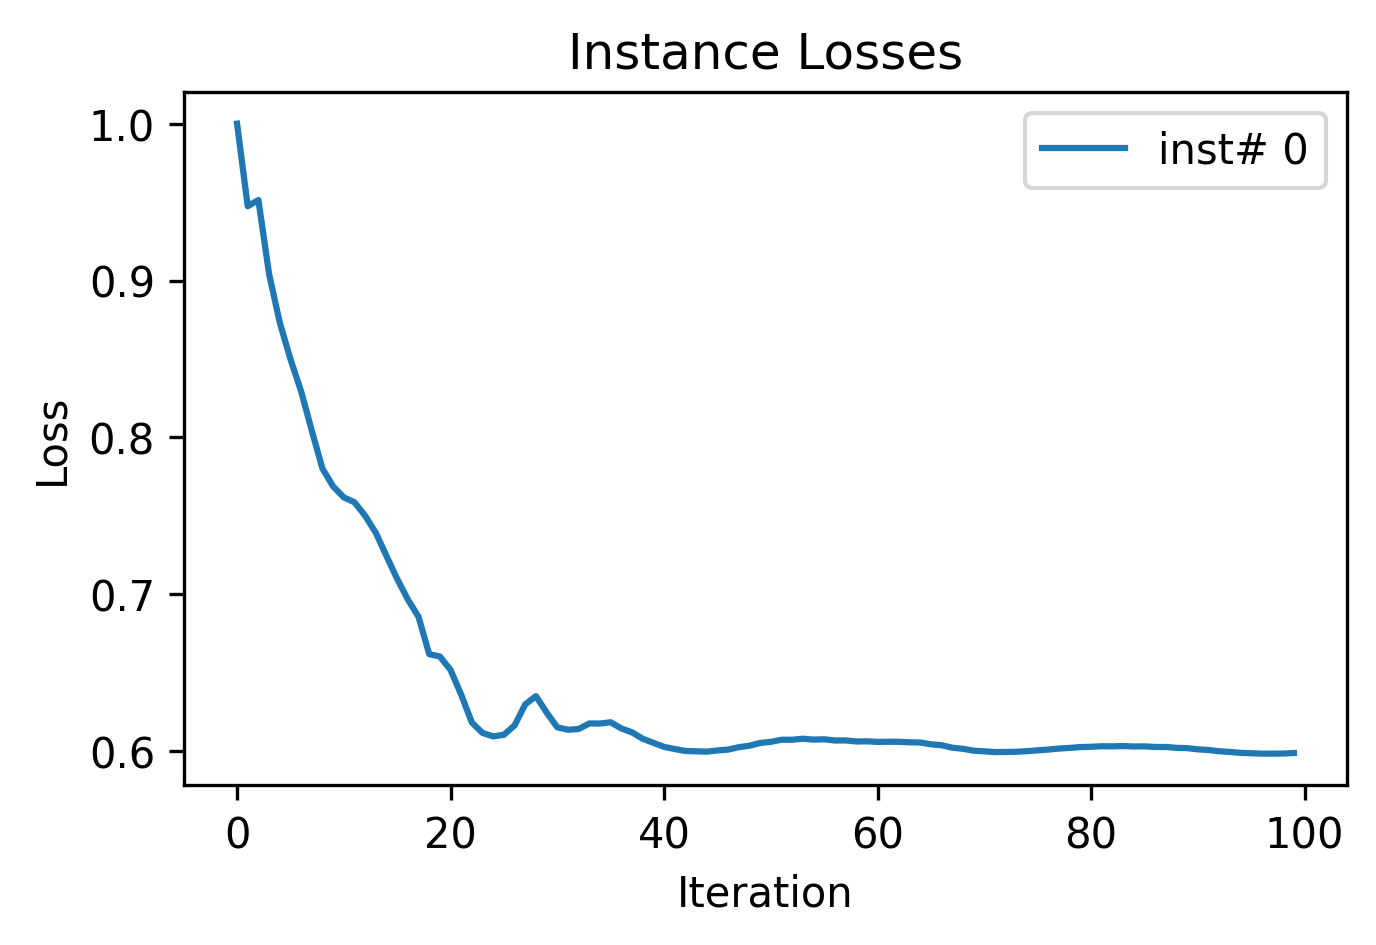

In [19]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

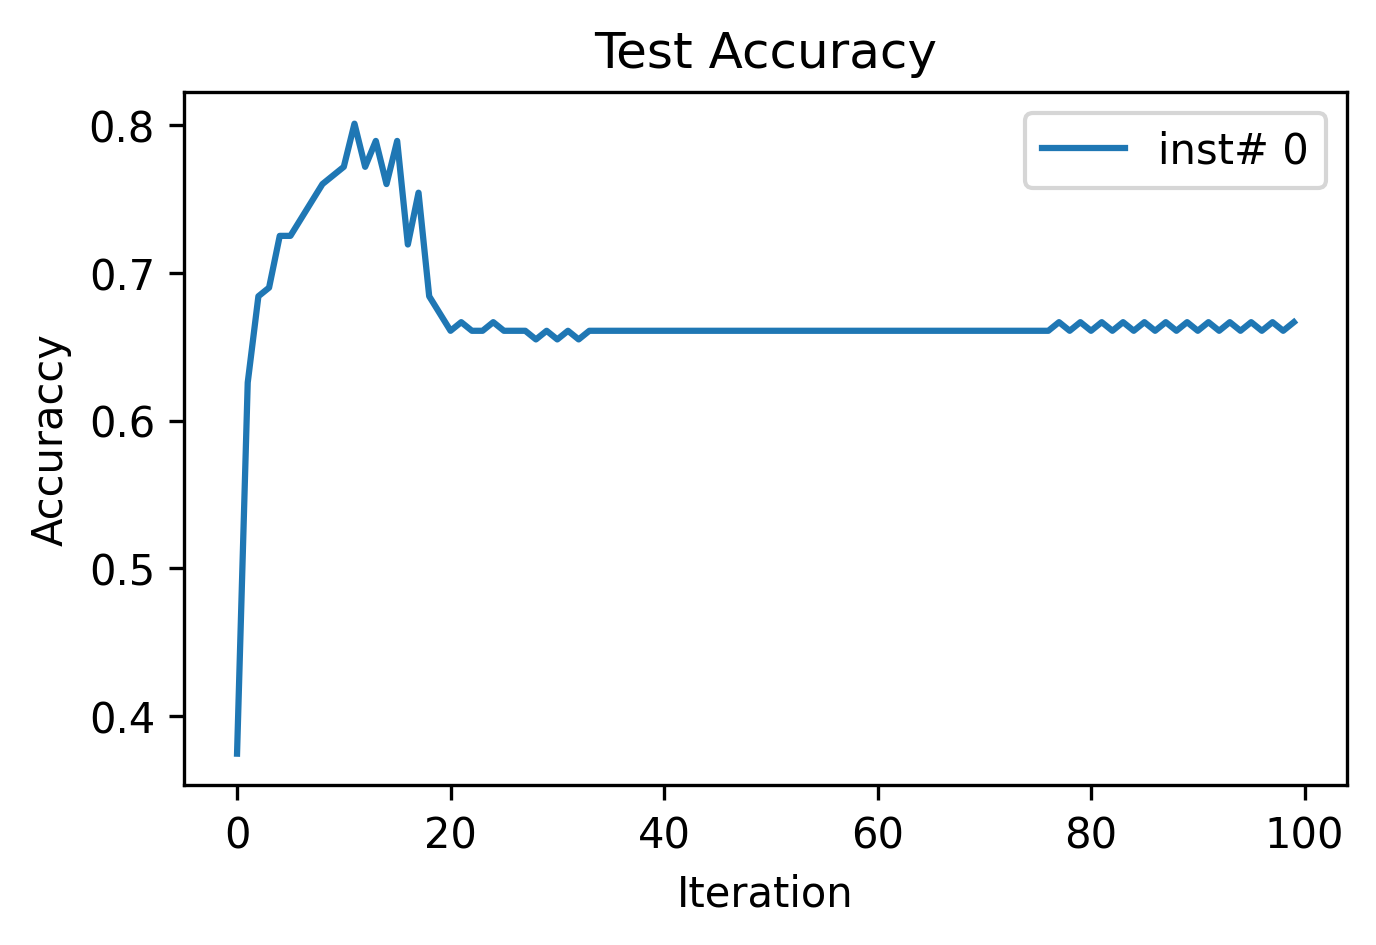

In [20]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [21]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [22]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
